# General Lake Model (v3.0)

Ref: Hipsey, M. R., Bruce, L. C., Boon, C., Busch, B., Carey, C. C., Hamilton, D. P., ... & Winslow, L. A. (2019). A General Lake Model (GLM 3.0) for linking with high-frequency sensor data from the Global Lake Ecological Observatory Network (GLEON). *Geoscientific Model Development*, 12(1), 473-523.

Code: https://github.com/AquaticEcoDynamics/glm-aed

This notebooke resumes the modeling processes based on python scripts. So first we are going to load the necessary python libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson


## Introduction

The General Lake Model (GLM) is a 1-D hydrodinamic model for enclosed acuatic ecosystems. It is writen in C language but it is configured so the user can configure inflows/outflows and meteorogical conditions without changing code structure, only using the parameterization file (glm3.nml). 

### Background and layer structure

The model is based on Lagrangian layer scheme first introduced by Imberger et al.(1978) and Imberger and Patterson (1981). Layers are named from botton to surface, and each layer (*i*) has a "control volume" that can change thickness by contracting and expanding in response to inflows, outflows, mixing with adjacent layers and surface mass fluxes.

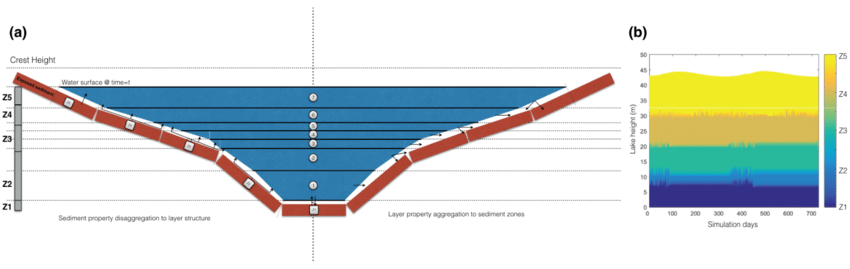

### Layer structure based on hypsographic curves

#### Lake form
The GLM uses a hypsographic curve to describe the relationship between the surface area of the lake and its elevation (or depth). This curve is derived from the lake’s bathymetry, which provides information about the shape and depth of the lake bottom. The hypsographic curve allows the model to understand how lake volume changes with depth, enabling accurate calculations of water volume changes within each model layer.

1) Input data provided by user: elevations (masl) and surface area
2) With that information we can calculate de volume of the lake at different depths.

The formula for calculating the volume between two depths, using the trapezoidal rule, is:

$$
V = \frac{h}{2} \times (A_1 + A_2)
$$

Where:
- \( h \) is the difference between the two depths.
- \( A_1 \) is the cross-sectional area at depth \( H_1 \).
- \( A_2 \) is the cross-sectional area at depth \( H_2 \).

Rewriting the formula:

$$
V = (0.5 \times (A_1 + A_2)) \times h
$$

Since we are calculating the total volume at consecutive depths, we need to add the volume calculated from the previous step. Here, \( h \) is the difference between depths \( H_1 \) and \( H_2 \):

$$
V = \left[ 0.5 \times (A_1 + A_2) \times (H_1 - H_2) \right] + V_{-1}
$$

# Step 2: Interpolate for finer depth increments

The goal here is to interpolate volume and area at finer depth increments (e.g., every 0.1 m) between known depths, allowing for a more detailed analysis of the lake’s characteristics.

## 1. Define finer depth increments

We define a set of finer depth points, \( H_{\text{fine}} \), which represent depths spaced regularly between the minimum and maximum depths in the dataset. Initially, we have no values for volume and area at these finer depths, so we will interpolate them.

## 2. Loop through depth intervals

For each consecutive pair of known depths, \( H_{i-1} \) and \( H_i \), we focus on the finer depth points that fall within this range:

\[
H_{i-1} \leq H_{\text{fine}} < H_i
\]

This means we interpolate between the known values at these depths, applying the formulas for volume and area.

## 3. Calculate interpolation coefficients

Since volume and area typically change non-linearly with depth, we use logarithmic interpolation. The interpolation coefficients \( \alpha_b \) for volume and \( \beta_b \) for area are calculated as follows:

\[
\alpha_b = \frac{\log_{10}(V_i) - \log_{10}(V_{i-1})}{\log_{10}(H_i) - \log_{10}(H_{i-1})}
\]

\[
\beta_b = \frac{\log_{10}(A_i) - \log_{10}(A_{i-1})}{\log_{10}(H_i) - \log_{10}(H_{i-1})}
\]

These coefficients describe the rate of change of volume and area between the two known depths.

## 4. Interpolate volume and area at finer depths

Using the coefficients \( \alpha_b \) and \( \beta_b \), we interpolate the volume \( V_{\text{fine}} \) and area \( A_{\text{fine}} \) for the finer depth points. The formulas for interpolation are:

\[
V_{\text{fine}}(H_{\text{fine}}) = V_{i-1} \times \left( \frac{H_{\text{fine}}}{H_{i-1}} \right)^{\alpha_b}
\]

\[
A_{\text{fine}}(H_{\text{fine}}) = A_{i-1} \times \left( \frac{H_{\text{fine}}}{H_{i-1}} \right)^{\beta_b}
\]

These equations apply the logarithmic interpolation to estimate the volume and area at the finer depths within the range \( H_{i-1} \leq H_{\text{fine}} < H_i \).

## 5. Handle the last depth point

For the last depth in the dataset, \( H_{\text{fine}} \geq H_{\text{max}} \), we directly assign the known values of volume \( V_{\text{max}} \) and area \( A_{\text{max}} \) since there are no finer depths beyond this point.

\[
V_{\text{fine}}(H_{\text{fine}} \geq H_{\text{max}}) = V_{\text{max}}
\]
\[
A_{\text{fine}}(H_{\text{fine}} \geq H_{\text{max}}) = A_{\text{max}}
\]

## 6. Calculate effective radius

Finally, assuming a circular cross-section for the lake, we can calculate the effective radius \( r_{\text{fine}} \) at each finer depth from the interpolated area values. The radius is calculated using the area of a circle:

\[
r_{\text{fine}} = \sqrt{\frac{A_{\text{fine}}}{\pi}}
\]

This provides an estimate of the radius of the lake at each depth, assuming the area represents a circular shape.


[ True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

/tmp/ipykernel_9342/2453768895.py:28: RuntimeWarning: divide by zero encountered in log10
  alpha_b = (np.log10(V[i]) - np.log10(V[i-1])) / (np.log10(H[i]) - np.log10(H[i-1]))
/tmp/ipykernel_9342/2453768895.py:32: RuntimeWarning: invalid value encountered in multiply
  V_fine[H_range] = V[i-1] * (H_fine[H_range] / H[i-1]) ** alpha_b


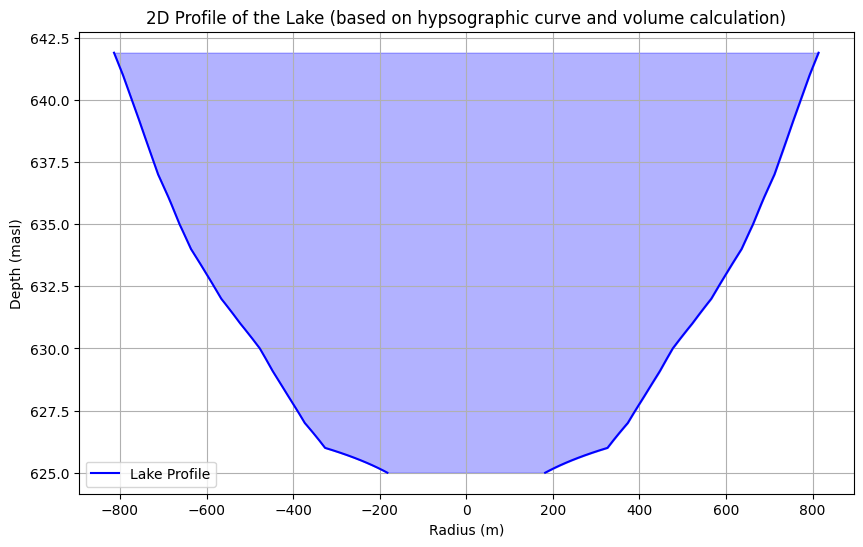

In [36]:
######################################################################
# Stimation of profile of the lake based on the hypsographic curve
######################################################################

# Provided data: depth (m) and surface area (m^2)
H = np.array([625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642])  # Depths (m)
A = np.array([104330, 334390, 437250, 524330, 620630, 714770, 856070, 1006520, 1132330, 1270740, 1378730, 1478430, 1592330, 1685780, 1776930, 1875870, 1976490, 2092750])

# Initialize volume array
V = np.zeros_like(H)  # Volumes will be stored here

# Step 1: Calculate cumulative volume between each pair of depth points
for b in range(1, len(H)):
    V[b] = V[b-1] + 0.5 * (A[b] + A[b-1]) * (H[b] - H[b-1])

# Step 2: Interpolate for finer depth increments
# Define finer depth increments (e.g., every 0.1 m)
H_fine = np.arange(H.min(), H.max(), 0.1)
V_fine = np.zeros_like(H_fine)
A_fine = np.zeros_like(H_fine)

for i in range(1, len(H)):
    H_range = (H_fine >= H[i-1]) & (H_fine < H[i])  # Finer points between known depths
    
    # Calculate interpolation coefficients
    alpha_b = (np.log10(V[i]) - np.log10(V[i-1])) / (np.log10(H[i]) - np.log10(H[i-1]))
    beta_b = (np.log10(A[i]) - np.log10(A[i-1])) / (np.log10(H[i]) - np.log10(H[i-1]))
    
    # Apply interpolation formula for volume and area
    V_fine[H_range] = V[i-1] * (H_fine[H_range] / H[i-1]) ** alpha_b
    A_fine[H_range] = A[i-1] * (H_fine[H_range] / H[i-1]) ** beta_b

# For the last point, we can directly use the last volume and area
V_fine[H_fine >= H[-1]] = V[-1]
A_fine[H_fine >= H[-1]] = A[-1]

# Calculate effective radius assuming circular shape for each area
r_fine = np.sqrt(A_fine / np.pi)  # Effective radius (m)

# Plot the lake profile
plt.figure(figsize=(10, 6))
plt.plot(r_fine, H_fine, label='Lake Profile', color='b')  # Right half of the profile
plt.plot(-r_fine, H_fine, color='b')  # Left half to make it symmetric
plt.fill_betweenx(H_fine, -r_fine, r_fine, color='blue', alpha=0.3)  # Fill the shape of the lake

# Add labels and title
plt.xlabel('Radius (m)')
plt.ylabel('Depth (masl)')
plt.title('2D Profile of the Lake (based on hypsographic curve and volume calculation)')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()